In [1]:
using DataFrames
using Requests
using TimeSeries
using MarketTechnicals
using PyPlot

    write(GZip.GZipStream, Array{#T<:Any, N<:Any}) at /home/juser/.julia/v0.5/GZip/src/GZip.jl:456
is ambiguous with: 
    write(Base.IO, Array{UInt8, N<:Any}) at io.jl:154.
To fix, define 
    write(GZip.GZipStream, Array{UInt8, N<:Any})
before the new definition.
 [inlined code] from ./error.jl:26
 in depwarn(::ASCIIString, ::Symbol) at ./deprecated.jl:64
 in Union(::Type{Array{Date,1}}, ::Type{Array{DateTime,1}}) at ./deprecated.jl:50
 in include(::ASCIIString) at ./boot.jl:240
 in include_from_node1(::ASCIIString) at ./loading.jl:417
 in include(::ASCIIString) at ./boot.jl:240
 in include_from_node1(::ASCIIString) at ./loading.jl:417
 in eval(::Module, ::Any) at ./boot.jl:243
 [inlined code] from ./sysimg.jl:11
 in require(::Symbol) at ./loading.jl:348
 [inlined code] from ./essentials.jl:82
 in include_string(::ASCIIString, ::ASCIIString) at ./loading.jl:371
 in execute_request_0x535c5df2(::ZMQ.Socket, ::IJulia.Msg) at /opt/julia_packages/.julia/v0.5/IJulia/src/execute_request.jl:

In [2]:
function getcsv(url)
    df = readtable(Requests.get_streaming(url))
end
function csvtotimearray(url)
    df = getcsv(url)
    timestamp = Date[Date(i) for i in df[1]] # parse dates
    colnames=AbstractString[string(i) for i in DataFrames.names(df)]
    dataarray=convert(Array, df[2:end])
    TimeArray(timestamp,dataarray,colnames[2:end])
end
function yahoo(symbol, startdate)
    str="a=$(Dates.month(startdate)-1)"*Dates.format(startdate, "&b=dd&c=yyyy")
    url="http://real-chart.finance.yahoo.com/table.csv?s="*symbol*"&"*str*"&g=d&ignore=.csv"
    csvtotimearray(url)
end
function quandl(symbol, startdate)
    str=Dates.format(startdate, "yyyy-mm-dd")
    url="https://www.quandl.com/api/v3/datasets/$symbol.csv?api_key=VKyXNok9WfyAwAHtZBCR&start_date=$str"
    csvtotimearray(url)
end

ZMQ.Socket) at /opt/julia_packages/.julia/v0.5/IJulia/src/IJulia.jl:141
 in (::IJulia.##24#30)() at ./task.jl:308
while loading /home/juser/.julia/v0.5/TimeSeries/src/apply.jl, in expression starting on line 105
 [inlined code] from ./error.jl:26
 in depwarn(::ASCIIString, ::Symbol) at ./deprecated.jl:64
 in Union(::Type{Int64}, ::Type{Float64}) at ./deprecated.jl:50
 [inlined code] from /home/juser/.julia/v0.5/TimeSeries/src/TimeSeries.jl:7
 in anonymous at ./<no file>:4294967295
 in include(::ASCIIString) at ./boot.jl:240
 in include_from_node1(::ASCIIString) at ./loading.jl:417
 in include(::ASCIIString) at ./boot.jl:240
 in include_from_node1(::ASCIIString) at ./loading.jl:417
 in eval(::Module, ::Any) at ./boot.jl:243
 [inlined code] from ./sysimg.jl:11
 in require(::Symbol) at ./loading.jl:348
 [inlined code] from ./essentials.jl:82
 in include_string(::ASCIIString, ::ASCIIString) at ./loading.jl:371
 in execute_request_0x535c5df2(::ZMQ.Socket, ::IJulia.Msg) at /opt/julia_package

quandl (generic function with 1 method)

In [3]:
startdate=Date(2007,12,20) # 2007-12-20 is 113 business days before 2008-6-3, since when CBOE/GVZ is available
symbol="QQQ"
ohlcv=yahoo(symbol, startdate)

  likely near In[3]:3
  likely near In[3]:3
  likely near In[3]:3
  likely near In[3]:3
  likely near In[3]:3
  likely near In[3]:3
  likely near In[3]:3
in Type at /home/juser/.julia/v0.5/TimeSeries/src/timearray.jl
  likely near In[3]:3
in Type at /home/juser/.julia/v0.5/TimeSeries/src/timearray.jl


2110x6 TimeSeries.TimeArray{Real,2,DataType} 2007-12-20 to 2016-05-09

             Open      High      Low       Close     Volume          Adj_Close  
2007-12-20 | 50.62     50.96     50.2      50.9      167341700       46.9395    
2007-12-21 | 51.68     51.9      51.48     51.85     107573500       47.8654    
2007-12-24 | 52.01     52.4      51.95     52.24     34499800        48.2255    
2007-12-26 | 52.13     52.63     52.0      52.5      58492100        48.4655    
⋮
2016-05-04 | 105.12    105.48    104.79    105.05    26689000        105.05     
2016-05-05 | 105.43    105.66    104.81    105.02    20724800        105.02     
2016-05-06 | 104.5     105.6     104.4     105.58    29731500        105.58     
2016-05-09 | 105.59    106.37    105.54    105.88    18852100        105.88     


  likely near /opt/julia_packages/.julia/v0.5/IJulia/src/kernel.jl:31
in gc_protect_handle at /opt/julia_packages/.julia/v0.5/ZMQ/src/ZMQ.jl
  likely near /opt/julia_packages/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /opt/julia_packages/.julia/v0.5/IJulia/src/kernel.jl:31
in gc_protect_handle at /opt/julia_packages/.julia/v0.5/ZMQ/src/ZMQ.jl
  likely near /opt/julia_packages/.julia/v0.5/IJulia/src/kernel.jl:31
in gc_protect_handle at /opt/julia_packages/.julia/v0.5/ZMQ/src/ZMQ.jl
  likely near /opt/julia_packages/.julia/v0.5/IJulia/src/kernel.jl:31
in gc_protect_handle at /opt/julia_packages/.julia/v0.5/ZMQ/src/ZMQ.jl


In [4]:
vix=quandl("CBOE/VIX", startdate)
vixarray=TimeArray(vix.timestamp,vix.values[:,end],["CBOE/VIX"])

  likely near In[4]:1
  likely near In[4]:1
  likely near In[4]:1
  likely near In[4]:1
in Type at /home/juser/.julia/v0.5/TimeSeries/src/timearray.jl
  likely near In[4]:1
in Type at /home/juser/.julia/v0.5/TimeSeries/src/timearray.jl
  likely near In[4]:2
  likely near In[4]:2
  likely near In[4]:2
  likely near In[4]:2
in Type at /home/juser/.julia/v0.5/TimeSeries/src/timearray.jl
  likely near In[4]:2
in Type at /home/juser/.julia/v0.5/TimeSeries/src/timearray.jl


2109x1 TimeSeries.TimeArray{Float64,1,DataType} 2007-12-20 to 2016-05-06

             CBOE/VIX  
2007-12-20 | 20.58     
2007-12-21 | 18.47     
2007-12-24 | 18.6      
2007-12-26 | 18.66     
⋮
2016-05-03 | 15.6      
2016-05-04 | 16.05     
2016-05-05 | 15.91     
2016-05-06 | 14.72     


In [5]:
vxn=quandl("CBOE/VXN", startdate)
vxnarray=TimeArray(vxn.timestamp,vxn.values[:,end],["CBOE/VXN"])

2109x1 TimeSeries.TimeArray{Float64,1,DataType} 2007-12-20 to 2016-05-06

             CBOE/VXN  
2007-12-20 | 23.15     
2007-12-21 | 20.9      
2007-12-24 | 21.42     
2007-12-26 | 21.32     
⋮
2016-05-03 | 19.02     
2016-05-04 | 19.32     
2016-05-05 | 19.14     
2016-05-06 | 17.54     


In [6]:
ovx=quandl("CBOE/OVX", startdate) # CBOE/OVX since 2007-05-10
ovxarray=TimeArray(ovx.timestamp,ovx.values,["CBOE/OVX"])

  likely near In[6]:2
  likely near In[6]:2
  likely near In[6]:2
  likely near In[6]:2
  likely near In[6]:2
in Type at /home/juser/.julia/v0.5/TimeSeries/src/timearray.jl


2110x1 TimeSeries.TimeArray{Float64,2,DataType} 2007-12-20 to 2016-05-06

             CBOE/OVX  
2007-12-20 | 29.17     
2007-12-21 | 26.91     
2007-12-24 | 27.48     
2007-12-26 | 27.46     
⋮
2016-05-03 | 45.78     
2016-05-04 | 44.76     
2016-05-05 | 44.82     
2016-05-06 | 42.47     


In [7]:
gvz=quandl("CBOE/GVZ", startdate) # CBOE/GVZ since 2008-6-3. 2007-12-20 is 113 business days before 2008-6-3.
gvzarray=TimeArray(gvz.timestamp,gvz.values,["CBOE/GVZ"])

1998x1 TimeSeries.TimeArray{Float64,2,DataType} 2008-06-03 to 2016-05-06

             CBOE/GVZ  
2008-06-03 | 22.89     
2008-06-04 | 22.69     
2008-06-05 | 22.78     
2008-06-06 | 23.6      
⋮
2016-05-03 | 18.7      
2016-05-04 | 19.47     
2016-05-05 | 18.46     
2016-05-06 | 18.65     


In [8]:
evz=quandl("CBOE/EVZ", startdate) # CBOE/EVZ since 2007-11-01
evzarray=TimeArray(evz.timestamp,evz.values,["CBOE/EVZ"])

2108x1 TimeSeries.TimeArray{Float64,2,DataType} 2007-12-20 to 2016-05-06

             CBOE/EVZ  
2007-12-20 | 9.93      
2007-12-21 | 9.7       
2007-12-26 | 9.06      
2007-12-27 | 8.56      
⋮
2016-05-03 | 10.14     
2016-05-04 | 10.15     
2016-05-05 | 10.2      
2016-05-06 | 9.52      


In [9]:
eurusd=quandl("ECB/EURUSD", startdate)
eurusdarray=TimeArray(eurusd.timestamp,eurusd.values,["ECB/EURUSD"])

2144x1 TimeSeries.TimeArray{Float64,2,DataType} 2007-12-20 to 2016-05-09

             ECB/EURUSD  
2007-12-20 | 1.4349      
2007-12-21 | 1.438       
2007-12-24 | 1.4398      
2007-12-27 | 1.4516      
⋮
2016-05-04 | 1.1505      
2016-05-05 | 1.1439      
2016-05-06 | 1.1427      
2016-05-09 | 1.1395      


In [10]:
ustreasury=quandl("USTREASURY/REALLONGTERM", startdate)
ustreasuryarray=TimeArray(ustreasury.timestamp,ustreasury.values,["USTREASURY/REALLONGTERM"])

2098x1 TimeSeries.TimeArray{Float64,2,DataType} 2007-12-20 to 2016-05-09

             USTREASURY/REALLONGTERM  
2007-12-20 | 2.0                      
2007-12-21 | 2.08                     
2007-12-24 | 2.13                     
2007-12-26 | 2.19                     
⋮
2016-05-04 | 0.66                     
2016-05-05 | 0.62                     
2016-05-06 | 0.66                     
2016-05-09 | 0.66                     


In [11]:
oil=quandl("OPEC/ORB", startdate)
oilarray=TimeArray(oil.timestamp,oil.values,["OPEC/ORB"])

2162x1 TimeSeries.TimeArray{Float64,2,DataType} 2007-12-20 to 2016-05-06

             OPEC/ORB  
2007-12-20 | 87.36     
2007-12-21 | 87.73     
2007-12-24 | 87.86     
2007-12-26 | 89.44     
⋮
2016-05-03 | 41.02     
2016-05-04 | 40.44     
2016-05-05 | 41.15     
2016-05-06 | 40.55     


In [12]:
gold=quandl("WGC/GOLD_DAILY_USD", startdate)
goldarray=TimeArray(gold.timestamp,gold.values./gold.values[1],["WGC/GOLD_DAILY_USD"])

2188x1 TimeSeries.TimeArray{Float64,2,DataType} 2007-12-20 to 2016-05-09

             WGC/GOLD_DAILY_USD  
2007-12-20 | 1.0                 
2007-12-21 | 1.0192              
2007-12-24 | 1.0192              
2007-12-25 | 1.0192              
⋮
2016-05-04 | 1.6133              
2016-05-05 | 1.6099              
2016-05-06 | 1.6209              
2016-05-09 | 1.5911              


In [13]:
ta=ohlcv["Close"];
predictcount=252;
rangelength=28;

In [14]:
function volumeoscillator(ohlcv, n=28, c="Volume")
    volume=ohlcv[c]
    vshort=ema(volume, Int(n/2))
    vlong=ema(volume, n)
    volumeoscillator=(vshort.-vlong)./vlong
    TimeArray(volumeoscillator.timestamp,volumeoscillator.values,["VolumeOscillator$n"])
end
# function volumeoscillator_all(ohlcv, n=28)
#     v0=volumeoscillator(ohlcv, Int(n/2))
#     v1=volumeoscillator(ohlcv, n)
#     v2=volumeoscillator(ohlcv, n*2)
#     r=merge2(v0,v1)
#     merge2(r,v2)
# end

volumeoscillator (generic function with 3 methods)

In [15]:
function chaikinmoneyflow(ohlcv, n=21, h="High", l="Low", c="Close", v="Volume")
    high=ohlcv[h]
    low=ohlcv[l]
    clo=ohlcv[c]
    volume=ohlcv[v]
    moneyflowvolume = (2.*clo.-low.-high)./(high.-low).*volume
    moneyflowsum=moving(moneyflowvolume,sum,n)
    volumesum=moving(volume,sum,n)
    re=moneyflowsum./volumesum
    TimeArray(re.timestamp, re.values, ["cmf$n"], ohlcv.meta)
end

chaikinmoneyflow (generic function with 6 methods)

In [16]:
function overlaps(t1::Vector, t2::Vector)
    i = j = 1
    idx1 = Int[]
    idx2 = Int[]
    while i <= length(t1) && j <= length(t2)
        if t1[i] > t2[j]
            j += 1
        elseif t1[i] < t2[j]
            i += 1
        else
            push!(idx1, i)
            push!(idx2, j)
            i += 1
            j += 1
        end
    end
    (idx1, idx2)        
end
function merge2(ta1, ta2)
    idx1, idx2 = overlaps(ta1.timestamp, ta2.timestamp)
    vals = [ta1[idx1].values ta2[idx2].values]
    TimeArray(ta1[idx1].timestamp, vals, [ta1.colnames; ta2.colnames])
end

merge2 (generic function with 1 method)

In [17]:
function bollingerbands2{T,N}(ta::TimeArray{T,N}, ma::Int, width::Real)
    tama   = sma(ta, ma)
    upband = tama .+ moving(ta, std, ma) .* width .* sqrt((ma-1)/ma) # take out Bessel correction, per algorithm
    dnband = tama .- moving(ta, std, ma) .* width .* sqrt((ma-1)/ma)
    bands  =  merge(upband, dnband) 
    merge(bands, tama, col_names = ["up", "down", "mean"])
end
function bollingerbands_deviation(ta, n=20, width=2)
    bbands=bollingerbands2(ta,n,width)
    bbprice=merge2(bbands,ta)
    bbstd=(bbands.values[:,1].-bbands.values[:,3])./2
    bbdev=(bbprice.values[:,4].-bbands.values[:,3])./(bbands.values[:,1].-bbands.values[:,3])
    TimeArray(bbands.timestamp, [bbdev bbstd], ["bbdev$n,$width", "bbstd$n,$width"])
end

bollingerbands_deviation (generic function with 3 methods)

In [18]:
function vwap_divergence(ohlcv, n=28)
    v1=vwap(ohlcv, Int(n/2))
    v2=vwap(ohlcv, n)
    v3=vwap(ohlcv, n*2)
    v4=vwap(ohlcv, n*4)
#     v5=vwap(ohlcv, n*8)
    d1=v1.-v2
    d2=v2.-v3
    d3=v3.-v4
#     d4=v4.-v5
    ta=merge2(v1,v2)
    ta=merge2(ta,v3)
    ta=merge2(ta,v4)
    ta=merge2(ta,d1)
    ta=merge2(ta,d2)
    ta=merge2(ta,d3)
#     ta=merge2(ta,v5)
#     ta=merge2(ta,d4)
    cname=["vwap$(Int(n/2))","vwap$n","vwap$(n*2)","vwap$(n*4)","vwap$(Int(n/2))-$n","vwap$n-$(n*2)","vwap$(n*2)-$(n*4)"]#,"vwap$(n*8)","vwap$(n*4)-$(n*8)"]
    TimeArray(ta.timestamp,ta.values,cname)
end

vwap_divergence (generic function with 2 methods)

In [19]:
function averagetruerange(ohlc, n=14, h="High", l="Low", c="Close")
    highs = merge(ohlc[h], lag(ohlc[c]))
    lows = merge(ohlc[l], lag(ohlc[c]))
    hi=convert(Array{Real,1},[maximum(highs.values[i,:]) for i=1:size(highs.values)[1]])
    lo=convert(Array{Real,1},[minimum(lows.values[i,:]) for i=1:size(lows.values)[1]])
    truehigh = TimeArray(highs.timestamp, hi, ["hi"], highs.meta)
    truelow  = TimeArray(lows.timestamp, lo, ["lo"], lows.meta)
    res = ema(truehigh .- truelow, n, wilder=true)
    TimeArray(res.timestamp, res.values, ["atr$n"], ohlc.meta)
end
function atr_divergence(ohlcv, n=28)
    v1=averagetruerange(ohlcv,Int(n/2));
    v2=averagetruerange(ohlcv,n);
    v3=averagetruerange(ohlcv,n*2);
    v4=averagetruerange(ohlcv,n*4);
#     v5=averagetruerange(ohlcv,n*8);
    d1=v1.-v2
    d2=v2.-v3
    d3=v3.-v4
#     d4=v4.-v5
    ta=merge2(v1,v2)
    ta=merge2(ta,v3)
    ta=merge2(ta,v4)
    ta=merge2(ta,d1)
    ta=merge2(ta,d2)
    ta=merge2(ta,d3)
#     ta=merge2(ta,v5)
#     ta=merge2(ta,d4)
    cname=["atr$(Int(n/2))","atr$n","atr$(n*2)","atr$(n*4)","atr$(Int(n/2))-$n","atr$n-$(n*2)","atr$(n*2)-$(n*4)"]#,"atr$(n*8)","atr$(n*4)-$(n*8)"]
    TimeArray(ta.timestamp,ta.values,cname)
end

atr_divergence (generic function with 2 methods)

In [20]:
function moneyflowindex(ohlcv, n=14, h="High", l="Low", c="Close", v="Volume")
    hi=ohlcv[h]
    lo=ohlcv[l]
    cl=ohlcv[c]
    volume=ohlcv[v]
    typical=(hi.+lo.+cl)./3
    diff=typical.-lag(typical)
    positive=convert(Array{Real,1},[i[2][1]>0?i[2][1]:0 for i in diff])
    negative=convert(Array{Real,1},[i[2][1]<0?abs(i[2][1]):0 for i in diff])
    pflow=TimeArray(diff.timestamp,positive,["Positive"]).*volume
    nflow=TimeArray(diff.timestamp,negative,["Negative"]).*volume
    psum=moving(pflow,sum,n)
    nsum=moving(nflow,sum,n)
    flowsum=psum.+nsum
    re=psum./flowsum
    TimeArray(re.timestamp, re.values, ["mfi$n"], ohlcv.meta)
end
function rsi_mfi_divergence(rsi, mfi, n=14)
    signal=ema(mfi.-rsi,5)
    TimeArray(signal.timestamp,signal.values,["rsi_mfi_divergence"])
end
function rsi_mfi_all(ohlcv, n=28, c="Close")
    ta=ohlcv[c]
    n0=Int(n/2)
    r0=rsi(ta,n0)./100
    r1=rsi(ta,n)./100
    m0=moneyflowindex(ohlcv,n0)
    m1=moneyflowindex(ohlcv,n)
    re=merge2(r1,m1)
    re=merge2(re,r0)
    re=merge2(re,m0)
end

rsi_mfi_all (generic function with 3 methods)

In [21]:
function macd2(ta, fast=12, slow=26, signal=9)
    mcd = ema(ta, fast) .- ema(ta, slow)
    sig = ema(mcd, signal)
    r = merge(mcd, sig, col_names=["macd", "signal"])
#     merge(r, mcd .- sig, col_names=[r.colnames; ["histogram"]])
end

macd2 (generic function with 4 methods)

In [22]:
function priceindex(ta, n=28)
    high=moving(ta, maximum, n)
    low=moving(ta, minimum, n)
    lh=merge(low, high, col_names = ["min", "max"])
    lh2=lh
    for i=1:n-1
        lh2=lead(lh2)
    end
    ranges=merge2(ta,lh2)
    index=[Real((i[2][1]-i[2][2])/(i[2][3]-i[2][2])) for i in ranges]
    TimeArray(ranges.timestamp, [ranges.values index], [ranges.colnames;["priceindex$n"]])
end

priceindex (generic function with 2 methods)

In [23]:
rsimfiarray=rsi_mfi_all(ohlcv, rangelength);
vwaparray=vwap_divergence(ohlcv, rangelength);
atrarray=atr_divergence(ohlcv, rangelength);
volumeoscillatorarray=volumeoscillator(ohlcv, rangelength);
macdarray=macd2(ta);
cmfarray=chaikinmoneyflow(ohlcv);
bbarray=bollingerbands_deviation(ta);
priceindexarray=priceindex(ta, rangelength);

  likely near In[23]:1
  likely near In[23]:1
  likely near In[23]:1
  likely near In[23]:1
  likely near In[23]:1
  likely near In[23]:1
  likely near In[23]:1
  likely near In[23]:1
  likely near In[23]:1
  likely near In[23]:1
  likely near In[23]:1
  likely near In[23]:1
  likely near In[23]:1
  likely near In[23]:1
  likely near In[23]:1
  likely near In[23]:1
  likely near In[23]:1
  likely near In[23]:1
  likely near In[23]:1
  likely near In[23]:1
  likely near In[23]:1
in Type at /home/juser/.julia/v0.5/TimeSeries/src/timearray.jl
  likely near In[23]:1
in Type at /home/juser/.julia/v0.5/TimeSeries/src/timearray.jl
  likely near In[23]:2
  likely near In[23]:2
  likely near In[23]:2
  likely near In[23]:2
  likely near In[23]:2
  likely near In[23]:2
  likely near In[23]:3
  likely near In[23]:3
  likely near In[23]:3
  likely near In[23]:3
  likely near In[23]:3
  likely near In[23]:3
  likely near In[23]:3
  likely near In[23]:7
  likely near In[23]:7
  likely near In[23]:7


In [24]:
featurearray=merge2(bbarray,cmfarray)
featurearray=merge2(featurearray,macdarray);
featurearray=merge2(featurearray,volumeoscillatorarray);
featurearray=merge2(featurearray,rsimfiarray);
featurearray=merge2(featurearray,atrarray);
featurearray=merge2(featurearray,vwaparray);
featurearray=merge2(featurearray,ustreasuryarray);
featurearray=merge2(featurearray,vixarray);
featurearray=merge2(featurearray,vxnarray);
featurearray=merge2(featurearray,goldarray);
featurearray=merge2(featurearray,gvzarray);
featurearray=merge2(featurearray,oilarray);
featurearray=merge2(featurearray,ovxarray);
featurearray=merge2(featurearray,evzarray);
featurearray=merge2(featurearray,eurusdarray);

In [25]:
withlabel=merge2(featurearray,priceindexarray)

1938x37 TimeSeries.TimeArray{Real,2,DataType} 2008-06-03 to 2016-03-31

             bbdev20,2  bbstd20,2  cmf21   macd    signal  VolumeOscillator28  rsi     mfi28   rsi     mfi14   atr14   atr28   atr56   atr112  atr14-28  atr28-56  atr56-112  vwap14    vwap28    vwap56    vwap112   vwap14-28  vwap28-56  vwap56-112  USTREASURY/REALLONGTERM  CBOE/VIX  CBOE/VXN  WGC/GOLD_DAILY_USD  CBOE/GVZ  OPEC/ORB  CBOE/OVX  CBOE/EVZ  ECB/EURUSD  Close     min       max       priceindex28  
2008-06-03 | 0.0575     0.6262     0.0836  0.6056  0.7071  0.0229              0.5557  0.5948  0.5061  0.4624  0.8857  0.9359  1.0102  1.0544  -0.0502   -0.0743   -0.0442    49.2025   48.7275   46.4974   45.6937   0.475      2.2301     0.8036      2.12                     20.24     23.89     1.1056              22.89     121.68    41.75     9.98      1.5593      49.13     44.56     50.55     0.7629        
2008-06-04 | 0.5132     0.6436     0.1135  0.6083  0.6873  0.0399              0.598   0.5926  0.5986  0.482

In [26]:
withoutlabel=merge2(featurearray,ta)

1964x34 TimeSeries.TimeArray{Real,2,DataType} 2008-06-03 to 2016-05-06

             bbdev20,2  bbstd20,2  cmf21   macd    signal  VolumeOscillator28  rsi     mfi28   rsi     mfi14   atr14   atr28   atr56   atr112  atr14-28  atr28-56  atr56-112  vwap14    vwap28    vwap56    vwap112   vwap14-28  vwap28-56  vwap56-112  USTREASURY/REALLONGTERM  CBOE/VIX  CBOE/VXN  WGC/GOLD_DAILY_USD  CBOE/GVZ  OPEC/ORB  CBOE/OVX  CBOE/EVZ  ECB/EURUSD  Close     
2008-06-03 | 0.0575     0.6262     0.0836  0.6056  0.7071  0.0229              0.5557  0.5948  0.5061  0.4624  0.8857  0.9359  1.0102  1.0544  -0.0502   -0.0743   -0.0442    49.2025   48.7275   46.4974   45.6937   0.475      2.2301     0.8036      2.12                     20.24     23.89     1.1056              22.89     121.68    41.75     9.98      1.5593      49.13     
2008-06-04 | 0.5132     0.6436     0.1135  0.6083  0.6873  0.0399              0.598   0.5926  0.5986  0.4821  0.9053  0.9439  1.0128  1.0553  -0.0386   -0.069    -0.0425    49

In [27]:
dataoffset=length(withoutlabel)-length(withlabel)
lastdate=withlabel.timestamp[end]
lastdateidx=searchsortedfirst(withoutlabel.timestamp, lastdate)
splitidx=lastdateidx-predictcount+dataoffset
newfeatures=TimeArray(withoutlabel.timestamp[splitidx+1:end],withoutlabel.values[splitidx+1:end,:],withoutlabel.colnames);

In [28]:
training=TimeArray(withlabel.timestamp[1:splitidx],withlabel.values[1:splitidx,:],withlabel.colnames);

In [29]:
test=TimeArray(withlabel.timestamp[splitidx+1:end],withlabel.values[splitidx+1:end,:],withlabel.colnames);

In [30]:
rsiidx=findfirst(withlabel.colnames,"rsi")
mfiidx=findfirst(withlabel.colnames,"mfi$rangelength")
closeidx=findfirst(withlabel.colnames,"Close")

34

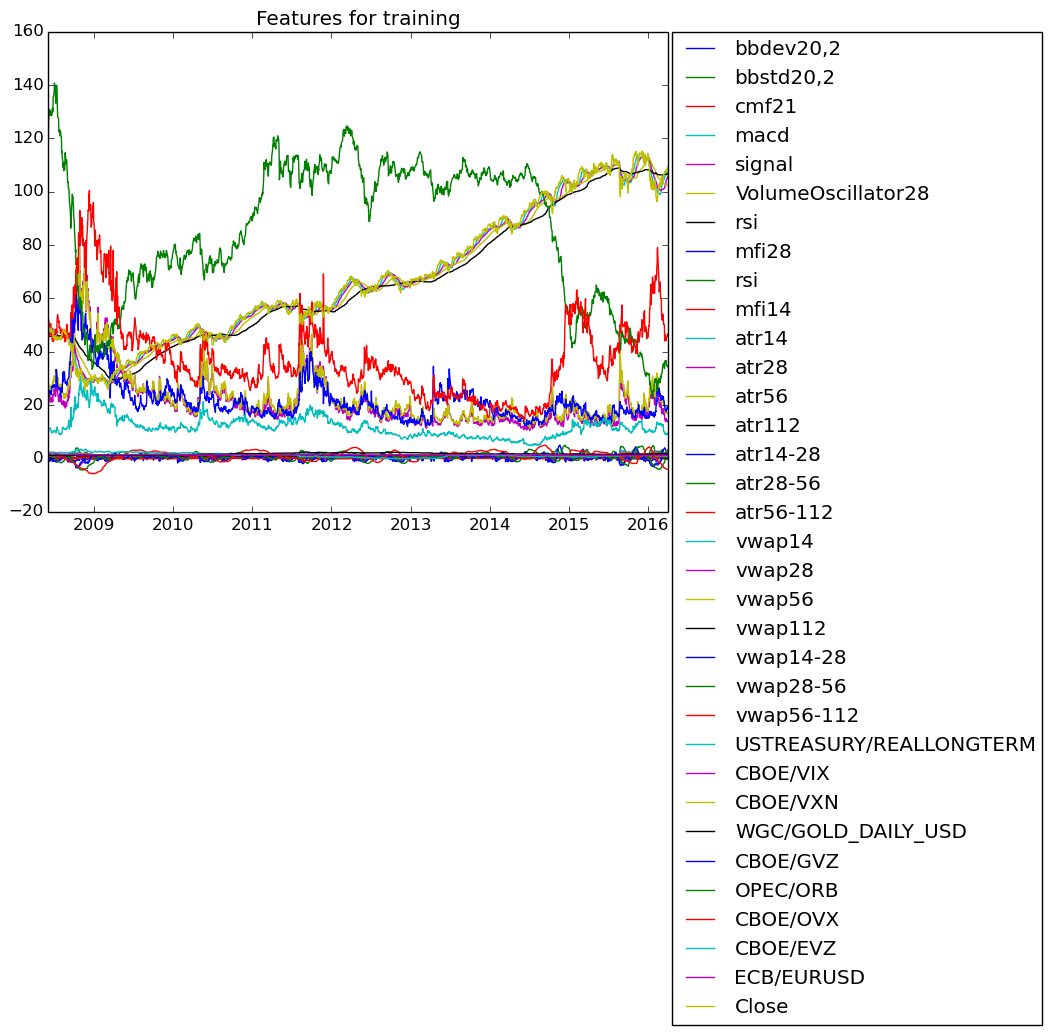

MethodError: MethodError: no method matching writemime(::Base.AbstractIOBuffer{Array{UInt8,1}}, ::MIME{symbol("image/svg+xml")}, ::PyCall.PyObject)
Closest candidates are:
  writemime(::IO, ::MIME{symbol("image/svg+xml")}, ::PyCall.PyObject)
  writemime(::IO, !Matched::AbstractString, ::Any)
  writemime(::IO, !Matched::MIME{symbol("text/csv")}, ::Any)
  ...

In [31]:
plot(withlabel.timestamp,withlabel.values[:,1:closeidx])
legend(withlabel.colnames[1:closeidx],bbox_to_anchor=(1.62, 1.02))
title("Features for training")

In [32]:
using DecisionTree
ntrees=100
pricerangeidx=closeidx+3
features=training.values[:,1:closeidx]
labels=convert(Array{Float64,1},training.values[:,pricerangeidx])
model = build_forest(labels,features, 2, ntrees, 5, 0.7)

Ensemble of Decision Trees
Trees:      100
Avg Leaves: 405.24
Avg Depth:  23.47

In [33]:
newlabels=apply_forest(model, newfeatures.values);
initvalue=withlabel.values[1,closeidx];

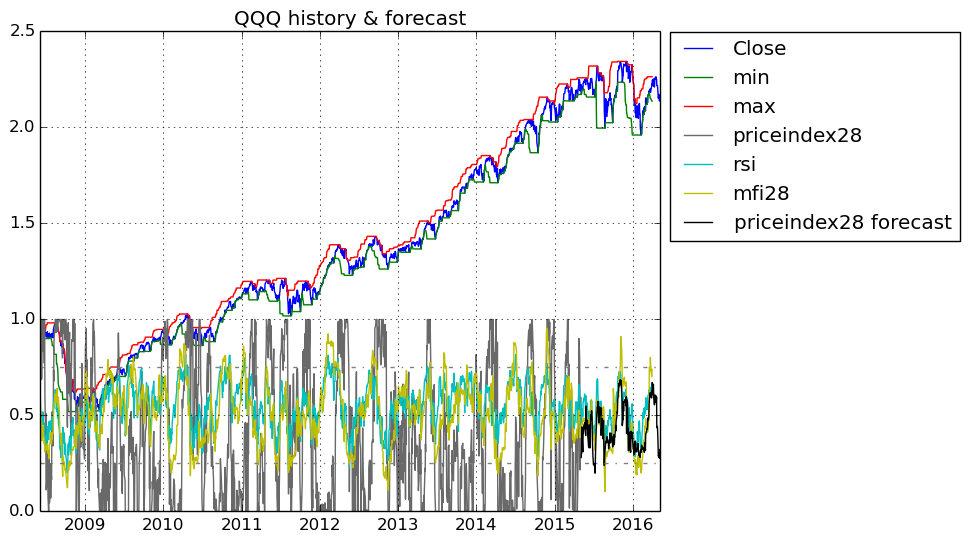

MethodError: MethodError: no method matching writemime(::Base.AbstractIOBuffer{Array{UInt8,1}}, ::MIME{symbol("image/svg+xml")}, ::PyCall.PyObject)
Closest candidates are:
  writemime(::IO, ::MIME{symbol("image/svg+xml")}, ::PyCall.PyObject)
  writemime(::IO, !Matched::AbstractString, ::Any)
  writemime(::IO, !Matched::MIME{symbol("text/csv")}, ::Any)
  ...

In [41]:
plot(withoutlabel.timestamp,withoutlabel.values[:,closeidx]./initvalue)
plot(withlabel.timestamp,withlabel.values[:,closeidx+1:closeidx+2]./initvalue)
plot(training.timestamp,training.values[:,pricerangeidx],c="DimGrey")
plot(withlabel.timestamp,withlabel.values[:,rsiidx],c="c")
plot(withlabel.timestamp,withlabel.values[:,mfiidx],c="y")
plot(newfeatures.timestamp,newlabels,c="k",linewidth=1)
title("$symbol history & forecast")
grid("on")
axhline(y=0.25,ls="-.",c="Grey")
axhline(y=0.75,ls="-.",c="Grey")
legend([withlabel.colnames[[closeidx,closeidx+1,closeidx+2,pricerangeidx,rsiidx,mfiidx]];"priceindex$rangelength forecast"],bbox_to_anchor=(1.5, 1.02))

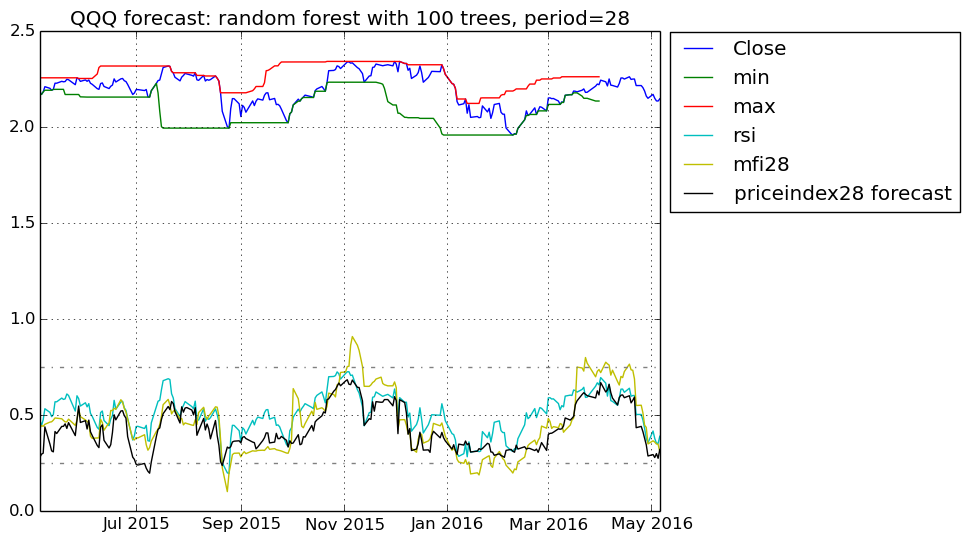

MethodError: MethodError: no method matching writemime(::Base.AbstractIOBuffer{Array{UInt8,1}}, ::MIME{symbol("image/svg+xml")}, ::PyCall.PyObject)
Closest candidates are:
  writemime(::IO, ::MIME{symbol("image/svg+xml")}, ::PyCall.PyObject)
  writemime(::IO, !Matched::AbstractString, ::Any)
  writemime(::IO, !Matched::MIME{symbol("text/csv")}, ::Any)
  ...

In [40]:
plot(newfeatures.timestamp,newfeatures.values[:,closeidx]./initvalue)
plot(test.timestamp,test.values[:,closeidx+1:closeidx+2]./initvalue)
plot(newfeatures.timestamp,newfeatures.values[:,rsiidx],c="c")
plot(newfeatures.timestamp,newfeatures.values[:,mfiidx],c="y")
plot(newfeatures.timestamp,newlabels,c="k",linewidth=1)
legend([test.colnames[[closeidx,closeidx+1,closeidx+2,rsiidx,mfiidx]];"priceindex$rangelength forecast"],bbox_to_anchor=(1.5, 1.02))
title("$symbol forecast: random forest with $ntrees trees, period=$rangelength")
grid("on")
# color names http://astropython.blogspot.ie/2012/02/additional-color-names-for-matplotlib.html
# http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.axhline
axhline(y=0.25,ls="-.",c="Grey")
axhline(y=0.75,ls="-.",c="Grey")

In [37]:
features=withlabel.values[:,1:closeidx]
labels=convert(Array{Float64,1},withlabel.values[:,pricerangeidx])
# run n-fold cross validation on regression forest
# using 2 random features, 10 trees, 3 folds, averaging of 5 samples/leaf (optional),
# and 0.7 porition of samples per tree (optional)
# returns array of coefficients of determination (R^2)
r2 = nfoldCV_forest(labels, features, 2, ntrees, 3, 5, 0.7)


Fold 1
Mean Squared Error:     0.028025324766640297
Correlation Coeff:      0.9257275896230763
Coeff of Determination: 0.7713822775615098

Fold 2
Mean Squared Error:     0.02745956363458271
Correlation Coeff:      0.9187185868619969
Coeff of Determination: 0.7660041254013125

Fold 3

3-element Array{Float64,1}:
 0.771382
 0.766004
 0.755215


Mean Squared Error:     0.028658560093553123
Correlation Coeff:      0.9192366229449096
Coeff of Determination: 0.7552154432123253

Mean Coeff of Determination: 0.7642006153917159
